## K-means clustering


This notebook use K-means clustering to cluster different users 

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import scipy.stats
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


### Load Data

In [2]:
cities_years = {
    'London': [2018, 2019, 2020],
    'Los_Angeles': [2018, 2019, 2020],
    'San_Francisco': [2018, 2019, 2020],
}

import seaborn as sns
cities_colors = {
    'London': sns.color_palette("Blues", n_colors = 3),
    'Los_Angeles': sns.color_palette("Reds", n_colors = 3),
    'San_Francisco': sns.color_palette("Greens", n_colors = 3),
}

In [3]:
from collections import defaultdict
dfs = defaultdict(dict)
dfall = []

for city, years in cities_years.items():
    for year in years:
        print("Loading: ", city, year)
        df = pd.read_csv("../data/raw/observations_v2/CNC_{}_{}.csv".format(city, year))
        dfs[city][year] = df
        dfall.append(df)

dfall = pd.concat(dfall)
dfs['London'][2018].head()

Loading:  London 2018
Loading:  London 2019
Loading:  London 2020
Loading:  Los_Angeles 2018
Loading:  Los_Angeles 2019
Loading:  Los_Angeles 2020
Loading:  San_Francisco 2018
Loading:  San_Francisco 2019
Loading:  San_Francisco 2020


,id,observed_on_string,time_observed_at,created_time_zone,created_at,updated_at,description,user_id,user_login,quality_grade,...,preferred_common_name,iconic_taxon_name,taxon_rank,taxon_parent_id,taxon_native,taxon_endemic,taxon_threatened,taxon_search_rank,taxon_observations,identifications
0,11479007,2018-04-27 7:52:34 am BST,2018-04-27T07:52:34+00:00,Etc/UTC,2018-04-27T07:06:17+00:00,2018-04-27T09:26:56+00:00,NaN,159021,muki,research,...,lesser celandine,Plantae,species,204212,True,False,False,26862,26862,"[{'user_id': 353381, 'category': 'improving', ..."
1,11480212,2018-04-27 8:39:41 am BST,2018-04-27T08:39:41+01:00,Europe/London,2018-04-27T09:02:52+01:00,2019-01-29T21:16:34+00:00,NaN,664459,lucyrobinsonnhm,research,...,Feral Pigeon,Aves,variety,3017,False,False,False,38831,38831,"[{'user_id': 29729, 'category': 'supporting', ..."
2,11480902,Fri Apr 27 2018 08:34:31 GMT+0100 (GMT+1),2018-04-27T08:34:31+02:00,Europe/Amsterdam,2018-04-27T10:42:01+02:00,2018-04-27T13:01:49+02:00,NaN,908315,tess26,casual,...,Spanish Bluebell,Plantae,species,56095,False,False,False,2801,2801,"[{'user_id': 908315, 'category': 'leading', 'd..."
3,11481097,Fri Apr 27 2018 09:54:35 GMT+0100 (GMT+1),2018-04-27T09:54:35+02:00,Europe/Amsterdam,2018-04-27T10:54:45+02:00,2018-04-27T22:23:41+02:00,NaN,796473,bryonycross,research,...,Green Alkanet,Plantae,species,156638,False,False,False,4509,4509,"[{'user_id': 160, 'category': 'improving', 'di..."
4,11482247,2018-04-27 8:42:21 am BST,2018-04-27T08:42:21+01:00,Europe/London,2018-04-27T11:09:55+01:00,2018-04-27T16:37:31+01:00,NaN,664459,lucyrobinsonnhm,research,...,London Plane,Plantae,hybrid,49664,False,False,False,5475,5475,"[{'user_id': 160, 'category': 'supporting', 'd..."


In [4]:
lon_2018 = dfs['Los_Angeles'][2018]
lon_2018

,id,observed_on_string,time_observed_at,created_time_zone,created_at,updated_at,description,user_id,user_login,quality_grade,...,preferred_common_name,iconic_taxon_name,taxon_rank,taxon_parent_id,taxon_native,taxon_endemic,taxon_threatened,taxon_search_rank,taxon_observations,identifications
0,7936465,Sun Apr 29 2018 14:53:07 GMT-0700 (PDT),2018-04-29T14:53:07-07:00,America/Los_Angeles,2017-09-15T15:13:04-07:00,2018-05-03T14:53:12-07:00,On a pomegranate tree in the NHM edible garden,630902,noelstnick,research,...,NaN,Insecta,species,61257,True,False,False,2152,2152,"[{'user_id': 181940, 'category': 'supporting',..."
1,8261280,Sun Apr 29 2018 16:26:11 GMT-0700 (PDT),2018-04-29T16:26:11-07:00,America/Los_Angeles,2017-10-04T16:26:56-07:00,2019-10-25T19:57:22-07:00,On a pomegranate tree in the NHM edible garden,630902,noelstnick,needs_id,...,Snout and Bark Beetles,Insecta,superfamily,372852,False,False,False,127566,127566,"[{'user_id': 240872, 'category': 'improving', ..."
2,8481460,Sun Apr 29 2018 13:57:13 GMT-0700 (PDT),2018-04-29T13:57:13-07:00,America/Los_Angeles,2017-10-20T13:57:56-07:00,2018-05-03T14:51:28-07:00,On a pomegranate tree in the NHM edible garden,630902,noelstnick,research,...,Oleander Aphid,Insecta,species,55215,False,False,False,8263,8263,"[{'user_id': 630902, 'category': 'improving', ..."
3,8623537,Sun Apr 29 2018 16:54:17 GMT-0700 (PDT),2018-04-29T16:54:17-07:00,America/Los_Angeles,2017-10-30T16:55:45-07:00,2018-05-03T14:51:13-07:00,On a pomegranate tree in the NHM edible garden,630902,noelstnick,casual,...,Mexican Bush Sage,Plantae,species,50644,False,False,False,4397,4397,"[{'user_id': 630902, 'category': None, 'disagr..."
4,8762645,Sun Apr 29 2018 11:32:50 GMT-0700 (PDT),2018-04-29T11:32:50-07:00,America/Los_Angeles,2017-11-11T11:33:49-08:00,2018-10-24T14:30:26-07:00,On a pomegranate tree in the NHM edible garden,630902,noelstnick,research,...,mule fat,Plantae,species,52111,True,False,False,7131,7131,"[{'user_id': 630902, 'category': 'improving', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19416,63982127,2018/04/28 10:48 AM PDT,2018-04-28T10:48:00-07:00,America/Los_Angeles,2020-11-01T11:10:59-08:00,2020-11-01T11:10:59-08:00,is it a baby?,605471,michaelpatrickyoon,needs_id,...,miner's lettuce,Insecta,genus,518719,False,False,False,1457,1457,"[{'user_id': 605471, 'category': 'leading', 'd..."
19417,63982128,2018/04/28 10:48 AM PDT,2018-04-28T10:48:00-07:00,America/Los_Angeles,2020-11-01T11:11:00-08:00,2020-11-02T07:25:29-08:00,is it a baby?,605471,michaelpatrickyoon,research,...,California Tree Frog,Amphibia,species,24253,True,False,False,2619,2619,"[{'user_id': 605471, 'category': 'improving', ..."
19418,63982129,2018/04/28 10:48 AM PDT,2018-04-28T10:48:00-07:00,America/Los_Angeles,2020-11-01T11:11:00-08:00,2020-11-03T07:29:46-08:00,maybe?,605471,michaelpatrickyoon,needs_id,...,Ground Beetles,Insecta,family,372884,False,False,False,140713,140713,"[{'user_id': 605471, 'category': 'leading', 'd..."
19419,63982130,2018/04/28 10:48 AM PDT,2018-04-28T10:48:00-07:00,America/Los_Angeles,2020-11-01T11:11:00-08:00,2020-11-01T11:11:00-08:00,maybe?,605471,michaelpatrickyoon,needs_id,...,Oyster Mushrooms,Fungi,genus,48495,False,False,False,27677,27677,"[{'user_id': 605471, 'category': 'leading', 'd..."


# Calculate participation

## Get number of observations and identifications

In [5]:
def get_obs_idents_per_user(dfcity):
    """ Calculate the number of observations and identifications per user 
    
    Input:
    ------
     - dfcity: pd.DataFrame
         The observations data for one city.
    
    Returns:
    -------
     - dfobsident: pd.DataFrame
         Has the columns: user_id | n_obs | n_idents
    
    """
    from collections import defaultdict
    n_obs = defaultdict(int)
    n_idents = defaultdict(int)


    for _, row in dfcity.iterrows():
        # Count observation to user that observed
        user_obs = row['user_id']
        n_obs[user_obs] += 1

        # Count identications the user did
        identifications = eval(row['identifications'])
        for ident in identifications:
            user_ident = ident['user_id']
            if user_ident != user_obs:
                n_idents[user_ident] += 1
    # Create dataframe with observations, identifications
    dfobsident = pd.DataFrame([n_obs, n_idents]).T.reset_index().convert_dtypes().fillna(0)
    dfobsident.columns = ['user_id', 'n_obs', 'n_idents']
    dfobsident
    return dfobsident

## London 2018

In [6]:
dfcity = dfs['Los_Angeles'][2018]
la_2018 = get_obs_idents_per_user(dfcity)
la_2018

,user_id,n_obs,n_idents
0,630902,28,0
1,907908,92,1
2,74669,442,340
3,6743,158,14
4,81779,552,310
...,...,...,...
1861,2732808,0,1
1862,1281815,0,1
1863,242901,0,1
1864,901476,0,1


In [7]:
#test user 160
u160_2018 = la_2018.loc[la_2018['user_id']==160]
u160_2018

,user_id,n_obs,n_idents


In [8]:
print(la_2018.shape)
print(la_2018.dtypes)

(1866, 3)
user_id     Int64
n_obs       Int64
n_idents    Int64
dtype: object


In [9]:
la_2018.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,1866.0,699157.674169,569752.914323,1.0,262998.5,733440.0,916758.0,3765410.0
n_obs,1866.0,10.407824,59.160774,0.0,0.0,0.0,3.0,1414.0
n_idents,1866.0,12.146838,77.704982,0.0,0.0,1.0,4.0,2179.0


In [10]:
#log transform
#step before log transformation to avoid the zeros 
la_2018['obs_count_1']=la_2018['n_obs']+1
la_2018['ident_count_1']=la_2018['n_idents']+1

In [11]:
#log transform
la_2018['obs_count_log'] = np.log(la_2018['obs_count_1'])
la_2018['ident_count_log'] = np.log(la_2018['ident_count_1'])

In [12]:
la_2018.sort_values('user_id').head()

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
1145,1,0,45,1,46,0.0,3.828641
928,28,0,20,1,21,0.0,3.044522
1218,172,0,22,1,23,0.0,3.135494
1482,305,0,3,1,4,0.0,1.386294
1714,354,0,1,1,2,0.0,0.693147


In [13]:
#select varibles for plotting
df_select = la_2018[['user_id','obs_count_log', 'ident_count_log']]
#create a copy of your dataframe:
df_std = df_select.copy()

In [14]:
#Don't include the user_id column in the transformation:
col_names = ['obs_count_log', 'ident_count_log']
features = df_std[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [15]:
#assign the result to those two columns
df_std[col_names] = features
df_std.rename(columns={'obs_count_log': 'obs_count_2018', 'ident_count_log': 'ident_count_2018'}, inplace=True)
df_std.sort_values('user_id')
#print(df_std)

,user_id,obs_count_2018,ident_count_2018
1145,1,-0.688973,2.204778
928,28,-0.688973,1.585364
1218,172,-0.688973,1.657227
1482,305,-0.688973,0.275448
1714,354,-0.688973,-0.272103
...,...,...,...
1754,3582359,-0.688973,-0.272103
896,3591384,-0.139254,-0.819654
1267,3638742,-0.688973,0.451720
1471,3745917,-0.688973,-0.272103


In [16]:
#define cololor 
color_dict = {'high activity':'red',
              'identifiers':'blue',
              'observers':'green',
              'low activity':'orange'}

In [20]:
label_dict = {0:'high activity', 1:'low activity', 2:'identifiers',3:'observers'}

kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000).fit(df_std[['obs_count_2018',
                                                                        'ident_count_2018']])
df_std['cluster_2018'] = kmeans.labels_
df_std['user_type2018'] = [label_dict.get(i) for i in df_std.cluster_2018]
df_std.sort_values('user_id')

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018
1145,1,-0.688973,2.204778,2,identifiers
928,28,-0.688973,1.585364,2,identifiers
1218,172,-0.688973,1.657227,2,identifiers
1482,305,-0.688973,0.275448,1,low activity
1714,354,-0.688973,-0.272103,1,low activity
...,...,...,...,...,...
1754,3582359,-0.688973,-0.272103,1,low activity
896,3591384,-0.139254,-0.819654,1,low activity
1267,3638742,-0.688973,0.451720,1,low activity
1471,3745917,-0.688973,-0.272103,1,low activity


In [23]:
higha_2018 = df_std.loc[df_std['user_type2018']=='high activity']
higha_2018

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018
2,74669,4.143702,3.787236,0,high activity
3,6743,3.331063,1.319568,0,high activity
4,81779,4.319598,3.714490,0,high activity
5,27908,2.130695,2.187416,0,high activity
10,223005,4.580070,1.265067,0,high activity
...,...,...,...,...,...
736,97821,1.404005,2.316674,0,high activity
753,704502,2.413566,2.169663,0,high activity
754,5179,2.413566,1.265067,0,high activity
777,11060,1.053597,2.254686,0,high activity


In [24]:
lowa_2018 = df_std.loc[df_std['user_type2018']=='low activity']
lowa_2018

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018
14,793860,0.182312,-0.819654,1,low activity
16,898761,-0.139254,-0.819654,1,low activity
17,837822,0.182312,-0.819654,1,low activity
23,876210,-0.139254,-0.819654,1,low activity
24,732580,-0.139254,-0.819654,1,low activity
...,...,...,...,...,...
1861,2732808,-0.688973,-0.272103,1,low activity
1862,1281815,-0.688973,-0.272103,1,low activity
1863,242901,-0.688973,-0.272103,1,low activity
1864,901476,-0.688973,-0.272103,1,low activity


In [25]:
ob_2018 = df_std.loc[df_std['user_type2018']=='observers']
ob_2018

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018
0,630902,1.981555,-0.819654,3,observers
1,907908,2.905731,-0.272103,3,observers
6,679426,1.646196,-0.819654,3,observers
7,138840,1.725570,-0.819654,3,observers
8,453215,2.986728,0.048194,3,observers
...,...,...,...,...,...
877,1693477,0.854285,-0.819654,3,observers
891,3185945,0.410466,-0.819654,3,observers
895,118484,1.053597,0.275448,3,observers
897,752395,0.960186,-0.819654,3,observers


In [26]:
id_2018 = df_std.loc[df_std['user_type2018']=='identifiers']
id_2018

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018
57,17630,-0.139254,3.891270,2,identifiers
104,900683,0.182312,1.622112,2,identifiers
110,171166,0.410466,1.988890,2,identifiers
175,113881,0.182312,1.206525,2,identifiers
179,31367,-0.139254,1.265067,2,identifiers
...,...,...,...,...,...
1744,282384,-0.688973,1.074561,2,identifiers
1766,451364,-0.688973,1.723094,2,identifiers
1784,840497,-0.688973,0.999271,2,identifiers
1793,1009426,-0.688973,0.595745,2,identifiers


In [21]:
import seaborn


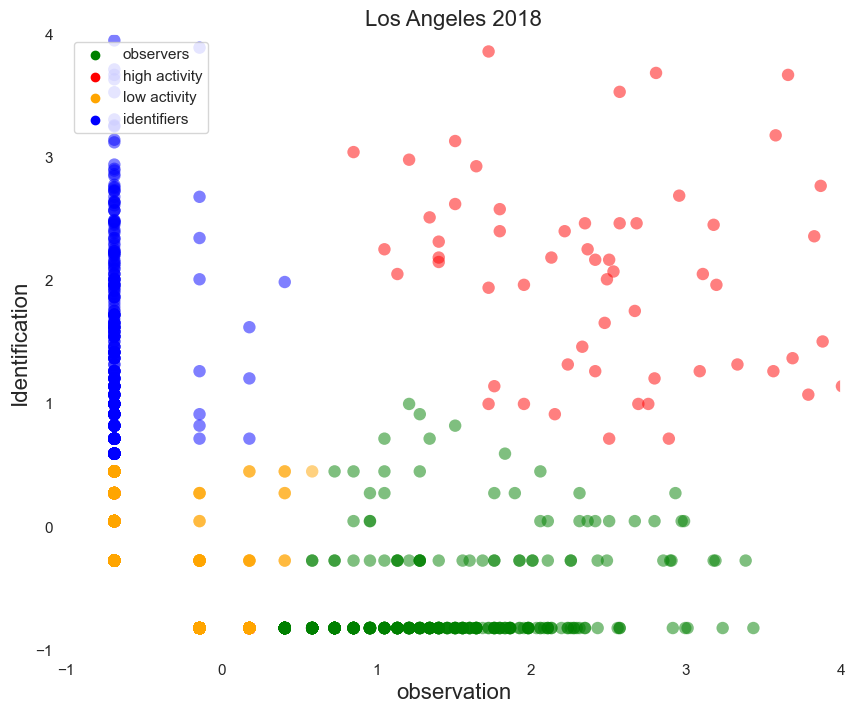

In [27]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(10,8))
ax = plt.axes()
sns.set(style="ticks")
ax = sns.scatterplot(data=df_std, x = 'obs_count_2018', y ='ident_count_2018',
                     hue='user_type2018',
                     palette=color_dict,
                     s=80, linewidth=0,alpha=0.5)
#ax.set(yscale="log")
#ax.set(xscale="log")
sns.set_style("ticks")
plt.legend(loc='upper left')
plt.title('Los Angeles 2018',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(18,9))
for i in range(df_select.shape[0]):
 plt.text(x=df_std.obs_count[i]+0.3,y=df_std.ident_count[i]+0.3,s=df_select.user_id[i], 
          fontdict=dict(color='blue',size=10),
          bbox=dict(facecolor='yellow',alpha=0.5))
ax = sns.scatterplot(data=df_std, x = 'obs_count', y ='ident_count',
                     hue='user_type2018',
                     #palette=color_dict,
                     s=20, linewidth=0)
plt.legend(loc='upper left')
plt.title('London 2018')
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
plt.savefig('scatter.png')
plt.show()

## Los Angeles 2019

In [28]:
dfcity = dfs['Los_Angeles'][2019]
la_2019 = get_obs_idents_per_user(dfcity)
la_2019

,user_id,n_obs,n_idents
0,496245,580,0
1,1653126,33,0
2,94012,275,229
3,1606340,1,0
4,154824,688,20
...,...,...,...
2728,1744345,0,2
2729,190992,0,1
2730,1241735,0,1
2731,584090,0,1


In [29]:
y = la_2019.loc[la_2019['user_id']==160]
y

,user_id,n_obs,n_idents


In [30]:
#step before log transformation to avoid the zeros 
la_2019['obs_count_1']=la_2019['n_obs']+1
la_2019['ident_count_1']=la_2019['n_idents']+1

In [31]:
#log transform
la_2019['obs_count_log'] = np.log(la_2019['obs_count_1'])
la_2019['ident_count_log'] = np.log(la_2019['ident_count_1'])

In [32]:
la_2019.sort_values('user_id')

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
1615,1,0,112,1,113,0.0,4.727388
1982,28,0,11,1,12,0.0,2.484907
2634,36,0,1,1,2,0.0,0.693147
2538,172,0,2,1,3,0.0,1.098612
2021,305,0,8,1,9,0.0,2.197225
...,...,...,...,...,...,...,...
2100,3618354,0,1,1,2,0.0,0.693147
2058,3638742,0,1,1,2,0.0,0.693147
1593,3679077,1,0,2,1,0.693147,0.0
1606,3753217,3,1,4,2,1.386294,0.693147


In [33]:
la_2019.sort_values('user_id').head()

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
1615,1,0,112,1,113,0.0,4.727388
1982,28,0,11,1,12,0.0,2.484907
2634,36,0,1,1,2,0.0,0.693147
2538,172,0,2,1,3,0.0,1.098612
2021,305,0,8,1,9,0.0,2.197225


In [34]:
#frames = [lon_2018, lon_2019]
#lon_2019 = pd.concat(frames)
#lon_2019.sort_values('user_id')

In [35]:
#select varibles for plotting
df_select_2019 = la_2019[['user_id','obs_count_log', 'ident_count_log']]

#create a copy of your dataframe:
df_std_2019 = df_select_2019.copy()
df_std_2019.sort_values('user_id')

,user_id,obs_count_log,ident_count_log
1615,1,0.0,4.727388
1982,28,0.0,2.484907
2634,36,0.0,0.693147
2538,172,0.0,1.098612
2021,305,0.0,2.197225
...,...,...,...
2100,3618354,0.0,0.693147
2058,3638742,0.0,0.693147
1593,3679077,0.693147,0.0
1606,3753217,1.386294,0.693147


In [36]:
col_names = ['obs_count_log', 'ident_count_log']
features = df_std_2019[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [37]:
#assign the result to those two columns
df_std_2019[col_names] = features
df_std_2019.rename(columns={'obs_count_log': 'obs_count_2019', 'ident_count_log': 'ident_count_2019'}, inplace=True)
df_std_2019

,user_id,obs_count_2019,ident_count_2019
0,496245,3.819007,-0.716676
1,1653126,1.747587,-0.716676
2,94012,3.275790,3.376199
3,1606340,-0.320054,-0.716676
4,154824,3.943429,1.574730
...,...,...,...
2728,1744345,-0.825903,0.110175
2729,190992,-0.825903,-0.194991
2730,1241735,-0.825903,-0.194991
2731,584090,-0.825903,-0.194991


In [38]:
#define cololor 
color1_dict = {'high activity':'red',
              'identifiers':'blue',
              'observers':'green',
              'low activity':'orange'}

In [41]:
label_dict = {0:'low activity', 1:'identifiers', 2:'observers',3:'high activity'}

kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000).fit(df_std_2019[['obs_count_2019',
                                                                        'ident_count_2019']])
df_std_2019['cluster_2019'] = kmeans.labels_
df_std_2019['user_type2019'] = [label_dict.get(i) for i in df_std_2019.cluster_2019]
df_std_2019.sort_values('user_id')

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
1615,1,-0.825903,2.841309,1,identifiers
1982,28,-0.825903,1.153545,1,identifiers
2634,36,-0.825903,-0.194991,0,low activity
2538,172,-0.825903,0.110175,0,low activity
2021,305,-0.825903,0.937026,1,identifiers
...,...,...,...,...,...
2100,3618354,-0.825903,-0.194991,0,low activity
2058,3638742,-0.825903,-0.194991,0,low activity
1593,3679077,-0.320054,-0.716676,0,low activity
1606,3753217,0.185796,-0.194991,0,low activity


In [43]:
higha_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='high activity']
higha_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
2,94012,3.275790,3.376199,3,high activity
4,154824,3.943429,1.574730,3,high activity
5,213838,2.667944,1.867854,3,high activity
12,10814,3.182860,3.897884,3,high activity
15,74669,3.539253,4.436556,3,high activity
...,...,...,...,...,...
1455,221981,0.987548,2.898986,3,high activity
1463,409074,2.433257,3.069395,3,high activity
1470,484431,1.462338,2.491555,3,high activity
1475,29392,2.987777,4.906514,3,high activity


In [44]:
lowa_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='low activity']
lowa_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
3,1606340,-0.320054,-0.716676,0,low activity
6,1671736,-0.320054,-0.716676,0,low activity
8,1671755,-0.024151,-0.716676,0,low activity
13,1660975,-0.320054,-0.716676,0,low activity
14,1124439,-0.320054,-0.716676,0,low activity
...,...,...,...,...,...
2728,1744345,-0.825903,0.110175,0,low activity
2729,190992,-0.825903,-0.194991,0,low activity
2730,1241735,-0.825903,-0.194991,0,low activity
2731,584090,-0.825903,-0.194991,0,low activity


In [45]:
ob_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='observers']
ob_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
0,496245,3.819007,-0.716676,2,observers
1,1653126,1.747587,-0.716676,2,observers
7,679426,1.703344,-0.716676,2,observers
10,1564978,1.150395,-0.194991,2,observers
11,929261,0.481699,-0.716676,2,observers
...,...,...,...,...,...
1555,1679997,0.594196,-0.716676,2,observers
1556,1686801,1.395948,-0.716676,2,observers
1561,1835665,1.935748,-0.716676,2,observers
1584,304117,1.100045,-0.716676,2,observers


In [46]:
id_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='identifiers']
id_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
9,204561,0.691645,1.791249,1,identifiers
125,1660660,-0.024151,0.937026,1,identifiers
224,1380746,-0.320054,1.458712,1,identifiers
254,39264,0.594196,1.959194,1,identifiers
496,1524947,0.185796,1.458712,1,identifiers
...,...,...,...,...,...
2654,86412,-0.825903,1.609743,1,identifiers
2670,1402207,-0.825903,1.321490,1,identifiers
2698,1781747,-0.825903,0.494639,1,identifiers
2706,662365,-0.825903,0.631860,1,identifiers


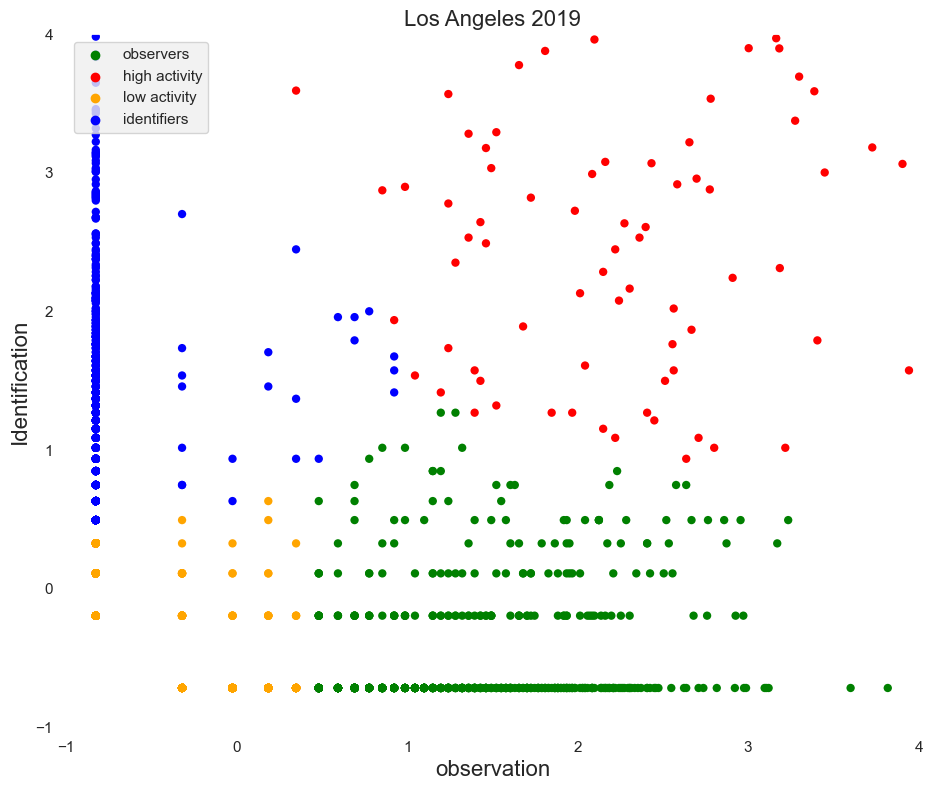

In [47]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))
ax = sns.scatterplot(data=df_std_2019, x = 'obs_count_2019', y ='ident_count_2019',
                     hue='user_type2019',
                     palette=color_dict,
                     s=36, linewidth=0)
plt.legend(loc='upper left')
plt.title('Los Angeles 2019',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

### merge two dataset 2018 and 2019

In [48]:
df = pd.merge(df_std, df_std_2019, on="user_id", how="right")
df.sort_values('user_id')      

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
1615,1,-0.688973,2.204778,2.0,identifiers,-0.825903,2.841309,1,identifiers
1982,28,-0.688973,1.585364,2.0,identifiers,-0.825903,1.153545,1,identifiers
2634,36,NaN,NaN,NaN,NaN,-0.825903,-0.194991,0,low activity
2538,172,-0.688973,1.657227,2.0,identifiers,-0.825903,0.110175,0,low activity
2021,305,-0.688973,0.275448,1.0,low activity,-0.825903,0.937026,1,identifiers
...,...,...,...,...,...,...,...,...,...
2100,3618354,NaN,NaN,NaN,NaN,-0.825903,-0.194991,0,low activity
2058,3638742,-0.688973,0.451720,1.0,low activity,-0.825903,-0.194991,0,low activity
1593,3679077,NaN,NaN,NaN,NaN,-0.320054,-0.716676,0,low activity
1606,3753217,NaN,NaN,NaN,NaN,0.185796,-0.194991,0,low activity


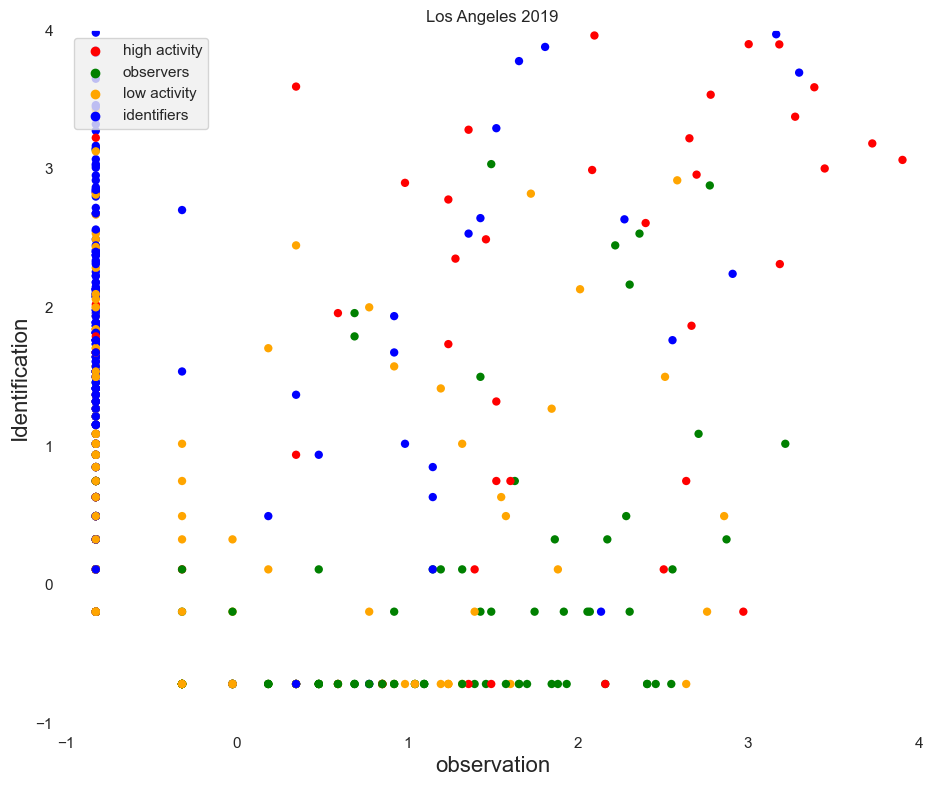

In [49]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)  
ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

plt.legend(loc='upper left')
plt.title('Los Angeles 2019')
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

In [50]:
#test 
higha_2019 = df.loc[df['user_type2019']=='high activity']
higha_2019.sort_values('user_id')

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
447,1850,4.066680,1.812618,0.0,high activity,3.544761,4.585548,3,high activity
1254,8094,NaN,NaN,NaN,NaN,2.242625,2.078279,3,high activity
12,10814,2.571270,3.532482,0.0,high activity,3.182860,3.897884,3,high activity
1278,12497,0.182312,0.717516,2.0,identifiers,1.809296,3.879668,3,high activity
523,12809,5.064716,3.441037,0.0,high activity,4.342233,4.808275,3,high activity
...,...,...,...,...,...,...,...,...,...
902,1529544,-0.688973,0.717516,2.0,identifiers,2.909140,2.242544,3,high activity
332,1613571,NaN,NaN,NaN,NaN,3.406197,1.791249,3,high activity
390,1645653,NaN,NaN,NaN,NaN,1.968188,1.269564,3,high activity
761,1665873,NaN,NaN,NaN,NaN,1.462338,3.179062,3,high activity


## Los Angeles 2020

In [51]:
dfcity = dfs['Los_Angeles'][2020]
la_2020 = get_obs_idents_per_user(dfcity)
la_2020.sort_values('user_id')

,user_id,n_obs,n_idents
1679,1,0,9
1860,28,0,67
2196,48,0,1
1790,477,0,13
2087,642,0,1
...,...,...,...
1675,3732227,1,0
2149,3747305,0,1
1676,3753217,1,0
2017,3767753,0,2


In [52]:
la_2020.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,2567.0,1.672069e+06,1.068225e+06,1.0,610469.0,1733310.0,2777992.5,3786723.0
n_obs,2567.0,7.621348e+00,3.378017e+01,0.0,0.0,1.0,4.0,720.0
n_idents,2567.0,7.984418e+00,7.724599e+01,0.0,0.0,0.0,2.0,3273.0


In [53]:
la_2020['obs_count_1']=la_2020['n_obs']+1
la_2020['ident_count_1']=la_2020['n_idents']+1

In [54]:
#log transform
la_2020['obs_count_log'] = np.log(la_2020['obs_count_1'])
la_2020['ident_count_log'] = np.log(la_2020['ident_count_1'])

In [55]:
la_2020.sort_values('user_id').head()

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
1679,1,0,9,1,10,0.0,2.302585
1860,28,0,67,1,68,0.0,4.219508
2196,48,0,1,1,2,0.0,0.693147
1790,477,0,13,1,14,0.0,2.639057
2087,642,0,1,1,2,0.0,0.693147


In [56]:
#frames1 = [lon_2019, lon_2020]
#lon_2020 = pd.concat(frames1)
#lon_2020.sort_values('user_id')

In [57]:
#select varibles for plotting
df_select_2020 = la_2020[['user_id','obs_count_log', 'ident_count_log']]
#create a copy of your dataframe:
df_std_2020 = df_select_2020.copy()
df_std_2020.sort_values('user_id')

,user_id,obs_count_log,ident_count_log
1679,1,0.0,2.302585
1860,28,0.0,4.219508
2196,48,0.0,0.693147
1790,477,0.0,2.639057
2087,642,0.0,0.693147
...,...,...,...
1675,3732227,0.693147,0.0
2149,3747305,0.0,0.693147
1676,3753217,0.693147,0.0
2017,3767753,0.0,1.098612


In [58]:
col_names = ['obs_count_log', 'ident_count_log']
features = df_std_2020[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [59]:
#assign the result to those two columns
df_std_2020[col_names] = features
df_std_2020.rename(columns={'obs_count_log': 'obs_count_2020', 'ident_count_log': 'ident_count_2020'}, inplace=True)
df_std_2020.sort_values('user_id')

,user_id,obs_count_2020,ident_count_2020
1679,1,-0.904228,1.463829
1860,28,-0.904228,3.197748
2196,48,-0.904228,0.008040
1790,477,-0.904228,1.768179
2087,642,-0.904228,0.008040
...,...,...,...
1675,3732227,-0.299098,-0.618934
2149,3747305,-0.904228,0.008040
1676,3753217,-0.299098,-0.618934
2017,3767753,-0.904228,0.374797


In [62]:
label_dict = {0:'low activity', 1:'identifiers', 2:'observers',3:'high activity'}

kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000).fit(df_std_2020[['obs_count_2020',
                                                                        'ident_count_2020']])
df_std_2020['cluster_2020'] = kmeans.labels_
df_std_2020['user_type2020'] = [label_dict.get(i) for i in df_std_2020.cluster_2020]
df_std_2020.sort_values('user_id')

,user_id,obs_count_2020,ident_count_2020,cluster_2020,user_type2020
1679,1,-0.904228,1.463829,1,identifiers
1860,28,-0.904228,3.197748,1,identifiers
2196,48,-0.904228,0.008040,0,low activity
1790,477,-0.904228,1.768179,1,identifiers
2087,642,-0.904228,0.008040,0,low activity
...,...,...,...,...,...
1675,3732227,-0.299098,-0.618934,0,low activity
2149,3747305,-0.904228,0.008040,0,low activity
1676,3753217,-0.299098,-0.618934,0,low activity
2017,3767753,-0.904228,0.374797,0,low activity


In [65]:
#test
user2020 = df_std_2020.loc[df_std_2020['user_id']==160]
user2020

,user_id,obs_count_2020,ident_count_2020,cluster_2020,user_type2020


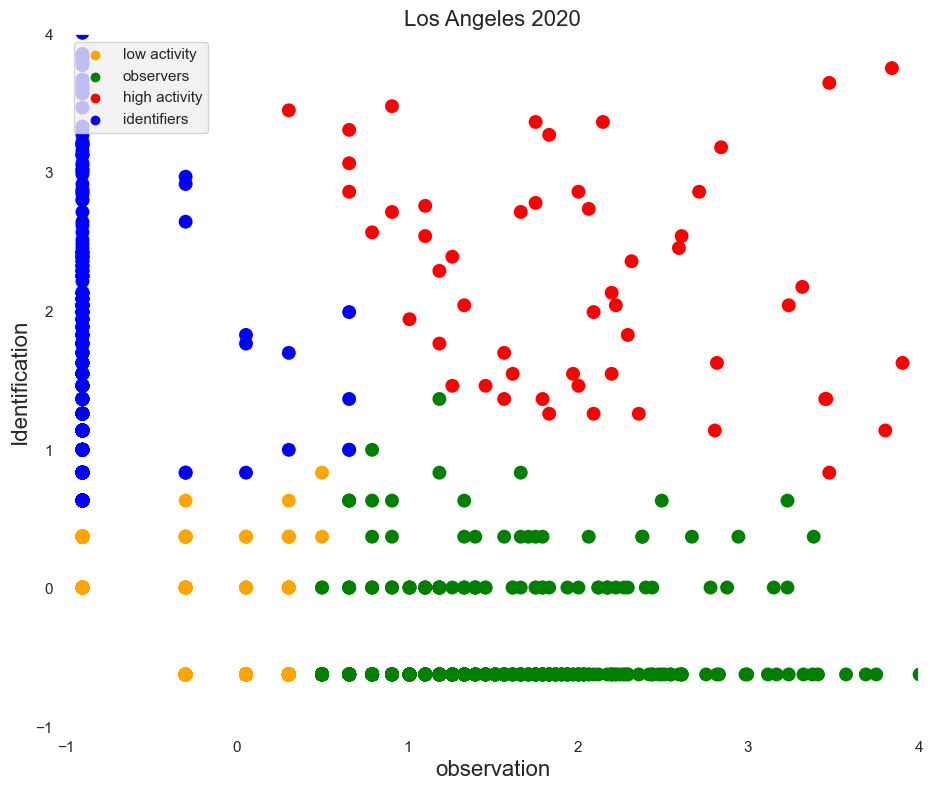

In [66]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))
ax = sns.scatterplot(data=df_std_2020, x = 'obs_count_2020', y ='ident_count_2020',
                     hue='user_type2020',
                     palette=color_dict,
                     s=100, linewidth=0)
plt.legend(loc='upper left')
plt.title('Los Angeles 2020',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

### Merge 2018,2019 and 2020

In [67]:
df1 = pd.merge(df,df_std_2020, on="user_id", how="right")
df1.sort_values('user_id') 

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020
1679,1,-0.688973,2.204778,2.0,identifiers,-0.825903,2.841309,1.0,identifiers,-0.904228,1.463829,1,identifiers
1860,28,-0.688973,1.585364,2.0,identifiers,-0.825903,1.153545,1.0,identifiers,-0.904228,3.197748,1,identifiers
2196,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.904228,0.008040,0,low activity
1790,477,-0.688973,1.988890,2.0,identifiers,-0.825903,1.213788,1.0,identifiers,-0.904228,1.768179,1,identifiers
2087,642,-0.688973,1.418440,2.0,identifiers,-0.825903,0.326694,0.0,low activity,-0.904228,0.008040,0,low activity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,3732227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.299098,-0.618934,0,low activity
2149,3747305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.904228,0.008040,0,low activity
1676,3753217,NaN,NaN,NaN,NaN,0.185796,-0.194991,0.0,low activity,-0.299098,-0.618934,0,low activity
2017,3767753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.904228,0.374797,0,low activity


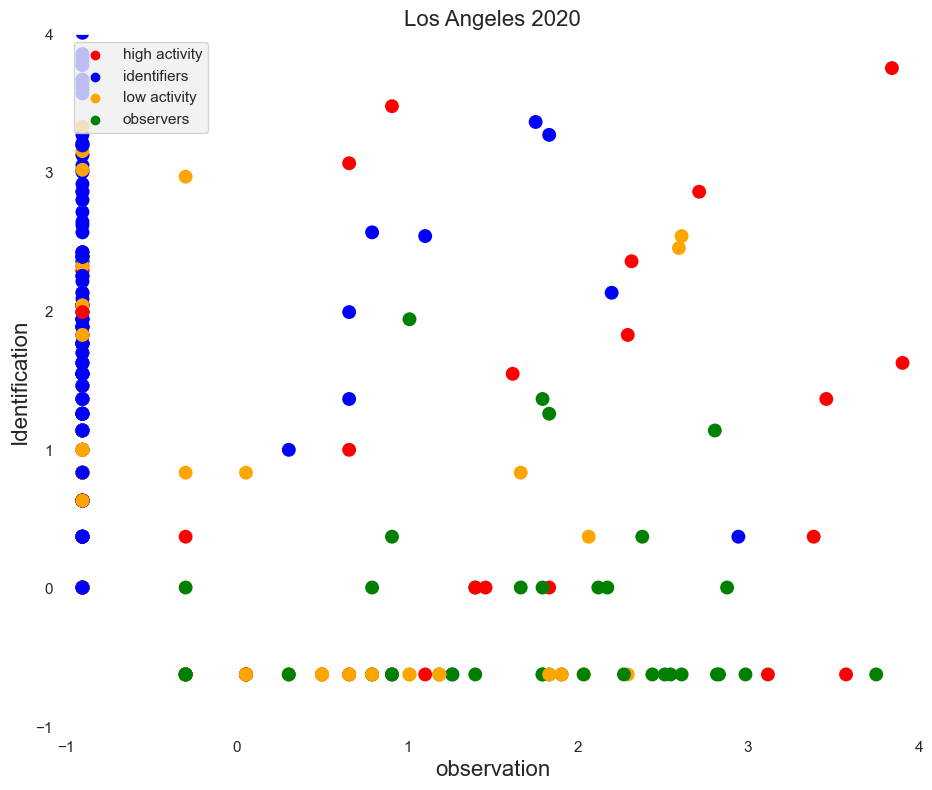

In [68]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)  
ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=100, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('Los Angeles 2020', fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

In [69]:
#check user 160 to see different clusters
user = df1.loc[df1['user_id']==160]
user

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020


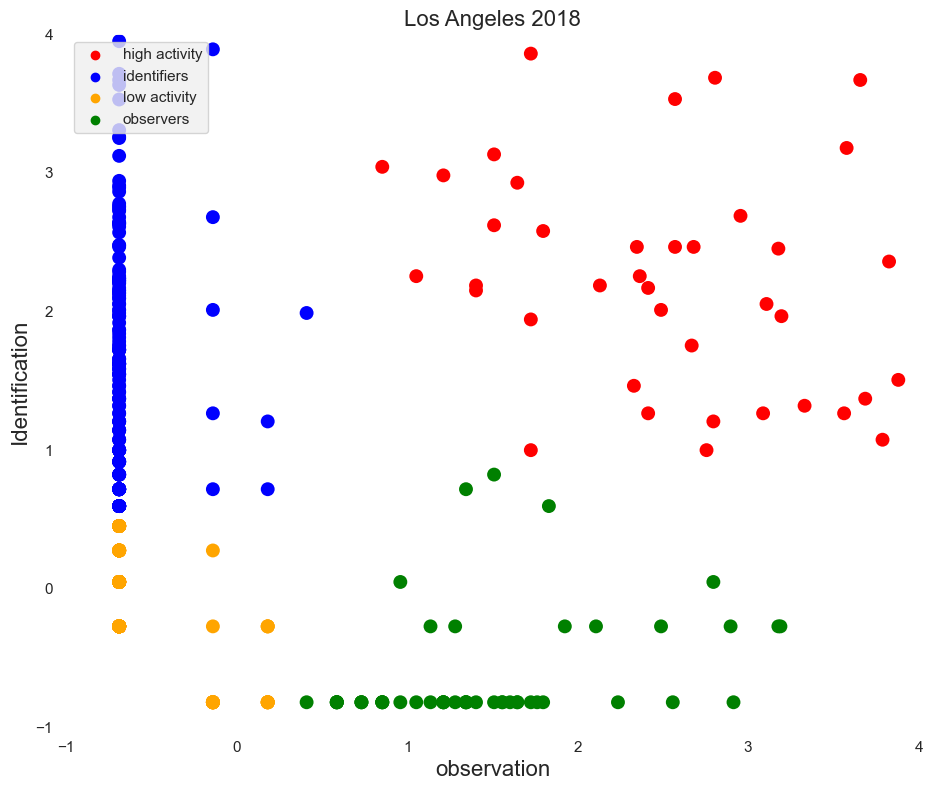

In [70]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

ax = sns.scatterplot(data=df1, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=100, linewidth=0)  
#ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('Los Angeles 2018',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

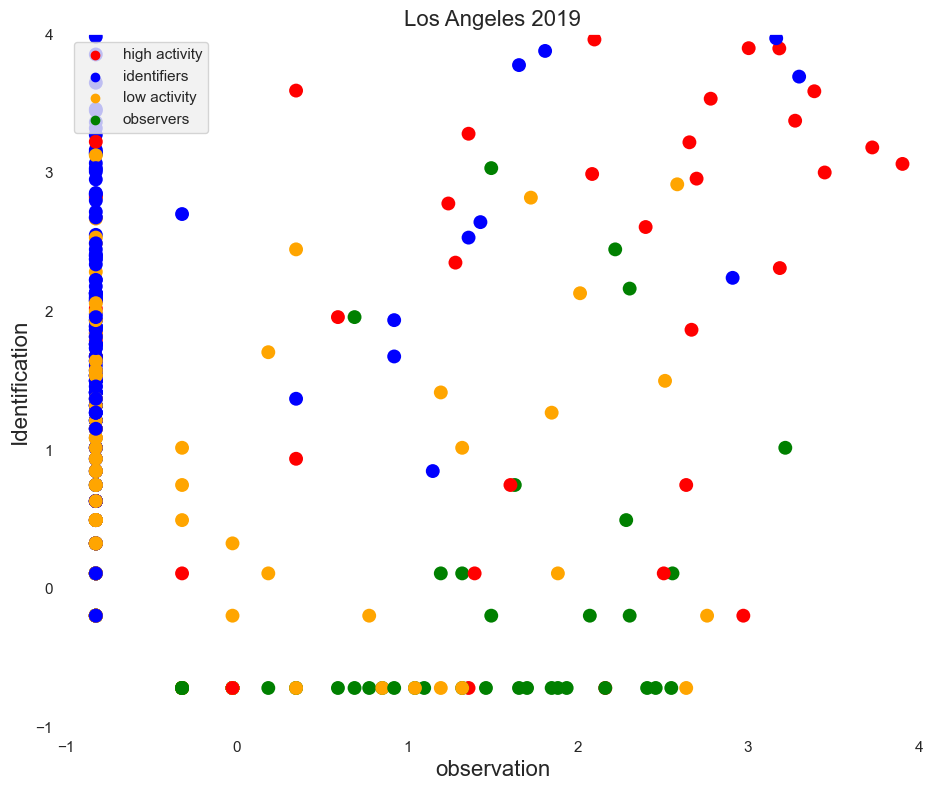

In [71]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))
#gs = GridSpec(4,4)

#ax = ax.add_subplot(gs[1:5,0:3])
ax = sns.scatterplot(data=df1, x = 'obs_count_2019', y ='ident_count_2019',  hue='user_type2018',  palette=color_dict, s=100, linewidth=0)  
#ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('Los Angeles 2019',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

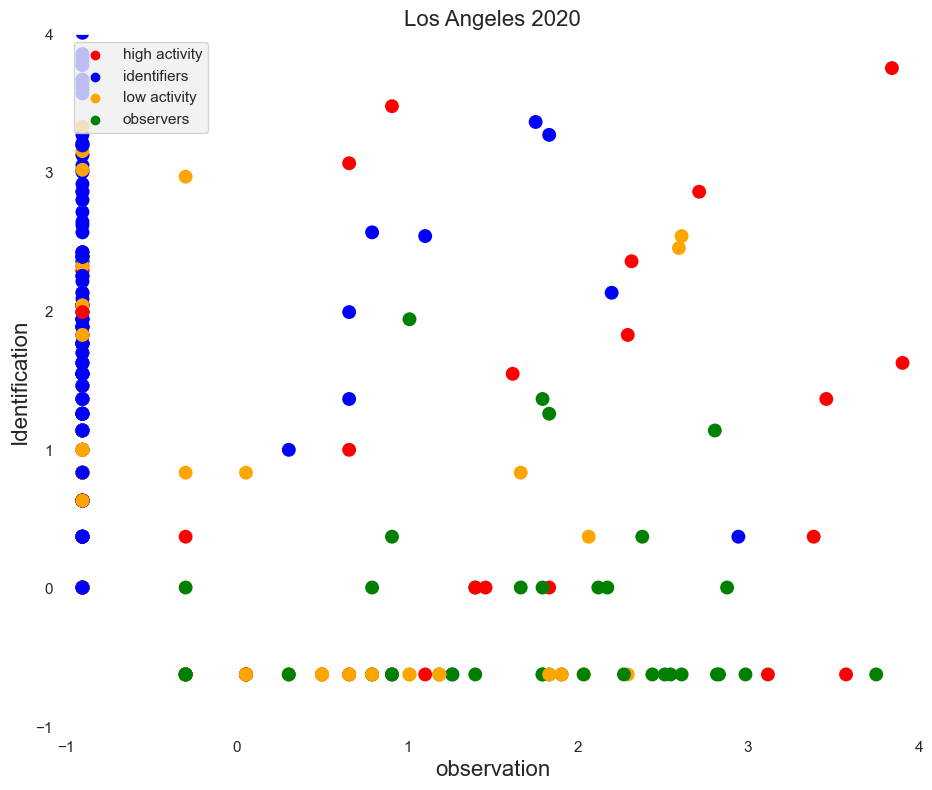

In [72]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',  hue='user_type2018',  palette=color_dict, s=100, linewidth=0)  
#ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('Los Angeles 2020',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

In [89]:
user_160 = df1.loc[df1['user_id']== 28]
user_160

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020
1860,28,-0.688973,1.585364,2.0,identifiers,-0.825903,1.153545,1.0,identifiers,-0.904228,3.197748,1,identifiers


In [74]:
df1.sort_values('user_id')

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020
1679,1,-0.688973,2.204778,2.0,identifiers,-0.825903,2.841309,1.0,identifiers,-0.904228,1.463829,1,identifiers
1860,28,-0.688973,1.585364,2.0,identifiers,-0.825903,1.153545,1.0,identifiers,-0.904228,3.197748,1,identifiers
2196,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.904228,0.008040,0,low activity
1790,477,-0.688973,1.988890,2.0,identifiers,-0.825903,1.213788,1.0,identifiers,-0.904228,1.768179,1,identifiers
2087,642,-0.688973,1.418440,2.0,identifiers,-0.825903,0.326694,0.0,low activity,-0.904228,0.008040,0,low activity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,3732227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.299098,-0.618934,0,low activity
2149,3747305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.904228,0.008040,0,low activity
1676,3753217,NaN,NaN,NaN,NaN,0.185796,-0.194991,0.0,low activity,-0.299098,-0.618934,0,low activity
2017,3767753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.904228,0.374797,0,low activity


## 2D Contour Plot (Density Plot)

D:\Anaconda\lib\site-packages\seaborn\distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


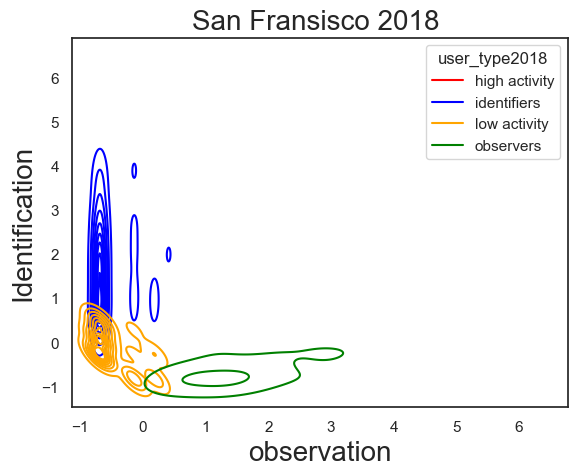

D:\Anaconda\lib\site-packages\seaborn\distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


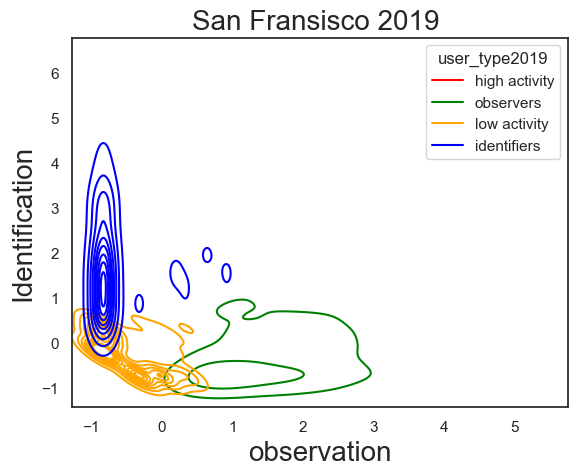

D:\Anaconda\lib\site-packages\seaborn\distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


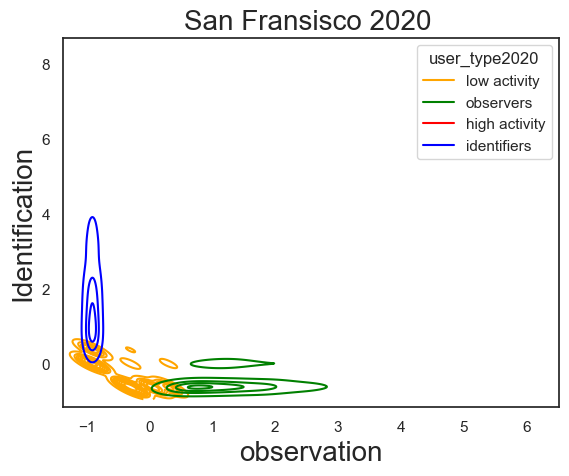

In [91]:
# Basic 2D density plot
#sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018,legend=True)
#sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019,hue='user_type2019')
sns.kdeplot(data=df1, x = 'obs_count_2018', y ='ident_count_2018', hue='user_type2018',palette=color_dict)
plt.title('San Fransisco 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

sns.kdeplot(data=df1, x = 'obs_count_2019', y ='ident_count_2019', hue='user_type2019',palette=color_dict)
plt.title('San Fransisco 2019 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

sns.kdeplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020', hue='user_type2020',palette=color_dict)
plt.title('San Fransisco 2020 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

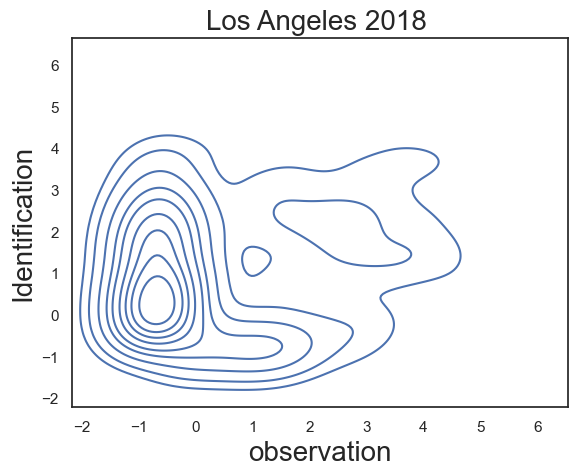

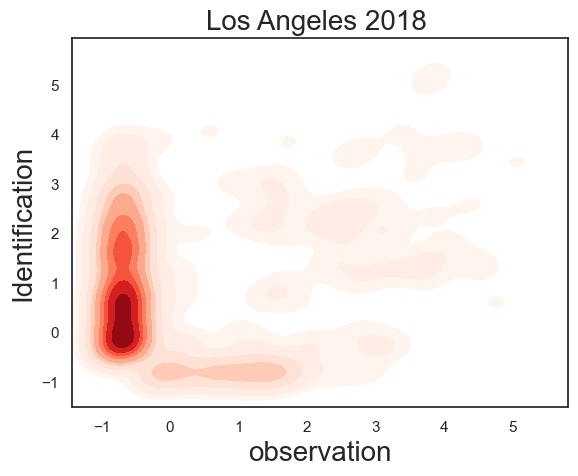

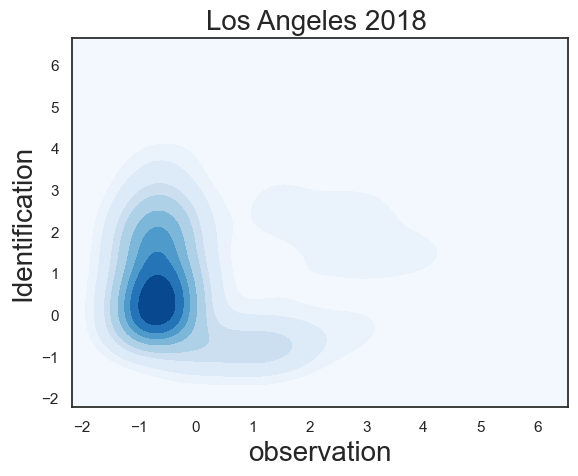

In [75]:
# set seaborn style
sns.set_style("white")

# Basic 2D density plot
sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018)
#sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019)
#sns.kdeplot(x=df1.obs_count_2020, y=df1.ident_count_2020)
plt.title('Los Angeles 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

# Custom the color, add shade and bandwidth
sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018,cmap="Reds", shade=True, bw_adjust=.5)
plt.title('Los Angeles 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

# Add thresh parameter
sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018, cmap="Blues", shade=True, thresh=0)
plt.title('Los Angeles 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

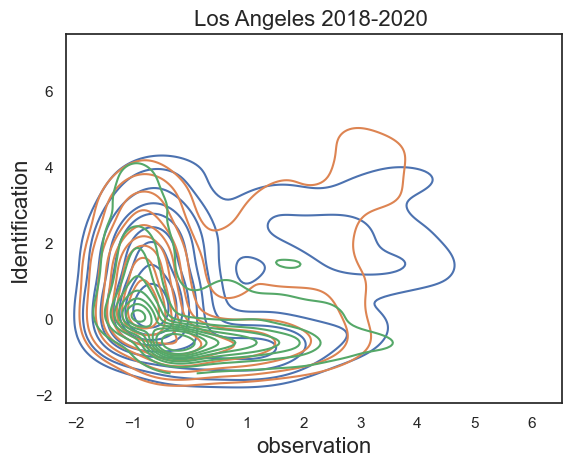

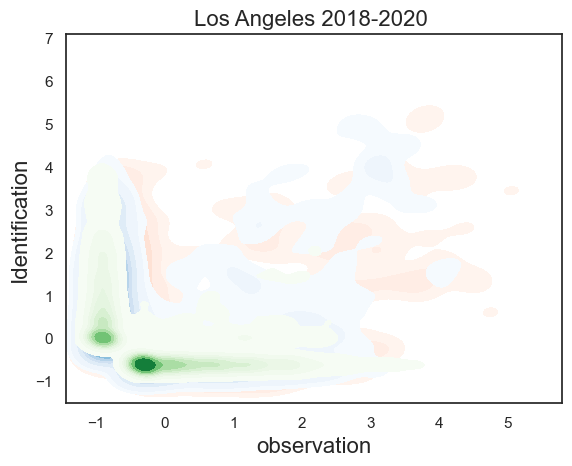

In [76]:
sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018 )
sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019)
sns.kdeplot(x=df1.obs_count_2020, y=df1.ident_count_2020)
plt.title('Los Angeles 2018-2020 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
plt.show()

sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018, cmap="Reds", shade=True, bw_adjust=.5)
sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019, cmap="Blues", shade=True, bw_adjust=.5)
sns.kdeplot(x=df1.obs_count_2020, y=df1.ident_count_2020, cmap="Greens", shade=True, bw_adjust=.5)
plt.title('Los Angeles 2018-2020 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
plt.show()

## Different types of User Activity 2018, 2019 and 2020

In [77]:
#high activity users 2018, 2019, 2020 
higha_2018 = df_std.loc[df_std['user_type2018']=='high activity']
higha_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='high activity']
higha_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='high activity']

In [78]:
#low activity users 2018, 2019, 2020 
lowa_2018 = df_std.loc[df_std['user_type2018']=='low activity']
lowa_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='low activity']
lowa_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='low activity']

In [79]:
#observers 2018, 2019, 2020 
obs_2018 = df_std.loc[df_std['user_type2018']=='observers']
obs_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='observers']
obs_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='observers']

In [80]:
#identifiers 2018, 2019, 2020 
iden_2018 = df_std.loc[df_std['user_type2018']=='identifiers']
iden_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='identifiers']
iden_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='identifiers']

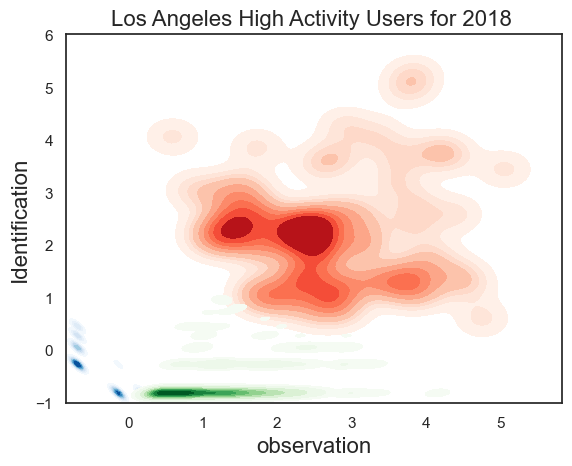

In [81]:
sns.kdeplot(x=higha_2018.obs_count_2018, y=higha_2018.ident_count_2018, cmap="Reds", shade=True, bw_adjust=.5)
sns.kdeplot(x=lowa_2018.obs_count_2018, y=lowa_2018.ident_count_2018, cmap="Blues", shade=True, bw_adjust=.5)
sns.kdeplot(x=obs_2018.obs_count_2018, y=obs_2018.ident_count_2018, cmap="Greens", shade=True, bw_adjust=.5)
#sns.kdeplot(x=iden_2018.obs_count_2018, y=iden_2018.ident_count_2018, cmap="Blues", shade=True, bw_adjust=.5)
plt.title('Los Angeles High Activity Users for 2018 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
plt.show()

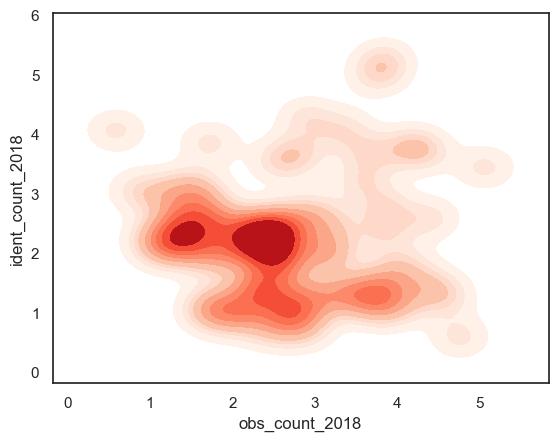

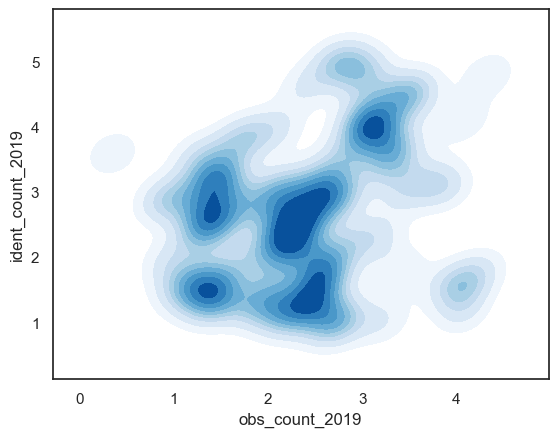

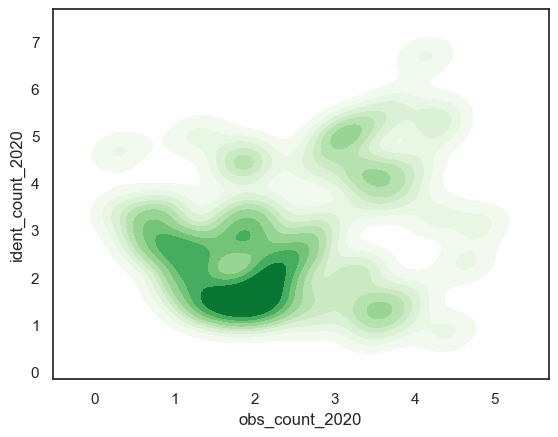

In [82]:
sns.kdeplot(x=higha_2018.obs_count_2018, y=higha_2018.ident_count_2018, cmap="Reds", shade=True, bw_adjust=.5)
plt.show()
sns.kdeplot(x=higha_2019.obs_count_2019, y=higha_2019.ident_count_2019, cmap="Blues", shade=True, bw_adjust=.5)
plt.show()
sns.kdeplot(x=higha_2020.obs_count_2020, y=higha_2020.ident_count_2020, cmap="Greens", shade=True, bw_adjust=.5)
plt.show()


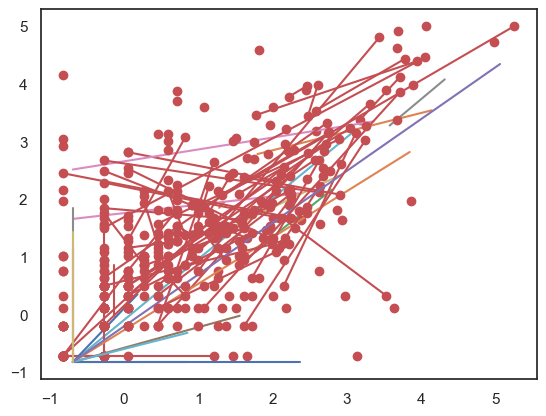

In [83]:
import matplotlib.pyplot as plt
x= df1['obs_count_2018']
y= df1['ident_count_2018']

x1= df1['obs_count_2019']
y1= df1['ident_count_2019']

plt.figure()
for i in range(0, len(x), 2):
    #plt.plot(x[i:i+2], y[i:i+2], 'ro-')
    plt.plot(x[i:i+2], x1[i:i+2],y[i:i+2], y1[i:i+2], 'ro-')
    # Show/save figure as desired.
plt.show()